# DRAFT - Market Analysis: Snapshot of 50 Banks Trading on the Stock Market

In [3]:
# import packages 
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys

src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from scipy import stats 
# these functions can be found in the src folder under d00_utils in ttest.py
from d00_utils.hypothesis_testing import welch_ttest, effective_dof, compute_pval_singlesided

%matplotlib inline

In [4]:
# import datasets
# Dataframe of bank statistics 
conf_dir = os.path.join(os.getcwd(), '..', 'conf')
sys.path.append(conf_dir)
bank_stats = pd.read_csv('../data/01_raw/all_stocks_stats.csv', index_col = 'ticker')
# Dataframe of public banks and ticker abbreviations
public_banks = pd.read_csv('../references/banks_tickers.txt', sep='\t',  skiprows = 1, 
                           names = ['Index', 'Name', 'Ticker'])

## I. Introduction

There has been renewed interest in banking stocks over the past few months. According to US News, experts agree that "the sector, as a whole could have a strong year, with the threat of a new recession appearing distant for the time being." 

In what follows we present a survey of 50 US publicly traded banks: 1-year return, trading volume, market capitalization, Welch's test for dependent samples, PE ratio and EPS for Small vs Big banks. 

## II. Datasets

It is difficult to undersatnd the potential for earnings between different banks. In this project, we work with two data sets. 

1. Bank Stats
1. Individual bank stocks 

**Bank Stats:** 
The bank stats dataset shows a  financial snapshot of 51 banks trading on the stock exchange. The dataset includes market information such as price change, average volume trading, market capitalization, earnings per share, and other stock related statistics. A data dictionary containing information on all 28 variables can be found in the reference folder. Below, we will highlight a number of key variables used in the project: 

1. year1ChangePercent - 1 year returns
1. avg10Volume - 10 Day average volume
1. avg30Volume - 30 day average volume
1. marketcap - market capitalization
1. peRatio - price-earnings ratio
1. ttmEPS - Trailing 12 month Earnings per share.

**Bank Stock Price (Individual):**
We also obtained a timeseries dataset of 100 days worth of stock market data for all 51 of the banks listed in the bank stats dataset.

## III. Key Project Metrics

Source: https://www.investopedia.com/

* **10- and 30-day average volume**: A stock's volume refers to the number of shares that are sold, or traded, over a certain period of time. 

* **Market capitalization (market cap)**: Market capitalization refers to the total dollar market value of a company's floating shares. It is calculated by multiplying a company's floating shares outstanding ( company's stock listed and availible for sale) by the current market price of one share. 

* **Price-earnings ratio (P/E ratio)**: The price-to-earnings ratio is the ratio for valuing a company that measures its current share price relative to its per-share earnings (EPS). It is a useful metric for evaluating the relative attractiveness of a company's stock price compared to the firm's current earnings

* **Earnings Per Share (EPS)**: Earnings per share (EPS) is calculated as a company's profit divided by the outstanding shares of its common stock. The resulting number serves as an indicator of a company's profitability. 

* **Trailing 12 months (TTM)**: TTM is the term for the data from the past 12 consecutive months used for reporting financial figures. A company's trailing 12 months represent its financial performance for a 12-month period; it does not typically represent a fiscal-year ending period.

## III. Questions & Analysis

### 1. Overview of  Return, Volume, and Market Cap

>**Question**: General overview of banks in the study

In [14]:
bank_stats['avg10VolMarketCap']=(bank_stats.avg10Volume / bank_stats.marketcap)*100

#Define function to split Volume into 3 groups
def get_volume_cat(pb):
    if pb <= 0.01:
        return '<1%'
    elif pb <= 0.05:
        return '1%-5%'
    else:
        return '>5%'

#Apply function defined above
bank_stats["volume_cat"] = bank_stats.avg10VolMarketCap.apply(lambda x: get_volume_cat(x))

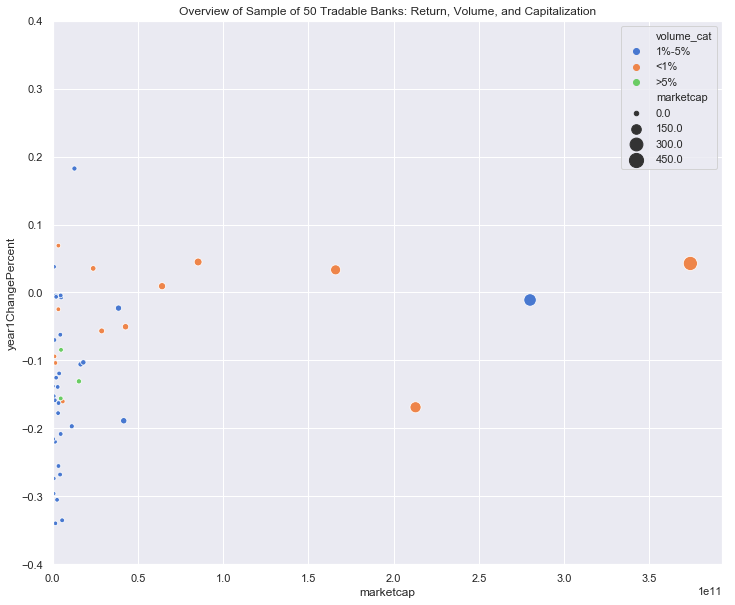

In [15]:
bank_stats.head()
marketCap = bank_stats.marketcap
yearReturn = bank_stats['year1ChangePercent']
volume = bank_stats["volume_cat"]
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.scatterplot(x=marketCap, y = yearReturn, hue = volume, palette=sns.color_palette("muted")[:3], size = marketCap/1e9, sizes = (20, 200))
plt.title('Overview of Sample of 50 Tradable Banks: Return, Volume, and Capitalization')
plt.ylim(-0.4, 0.4)
plt.xlim(0, None)
plt.show()

### 2. Average Volume Before and After Treatment (Time)

>**Question**: Is trading volume different for short vs long term time period, approximate dby 10-day vs 30-day average volume

In [18]:
#Calc additional data: 10-day and 30-day volume over market cap ratio
bank_stats['avg10VolRatio'] = (bank_stats.avg10Volume / bank_stats.marketcap)*100
bank_stats['avg30VolRatio'] = (bank_stats.avg30Volume / bank_stats.marketcap)*100

(0, 0.0865741309386195)

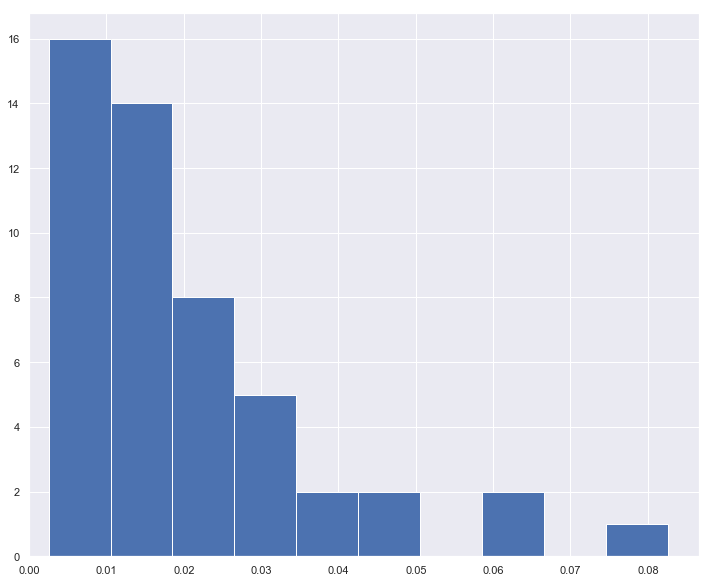

In [24]:
#Clean and inspect data visually, 10-day
sns.set(rc={'figure.figsize':(12,10)})
bank_stats.avg10VolRatio.dropna(axis=0, inplace=True)
bank_stats.avg10VolRatio.hist()
plt.xlim(0, None)

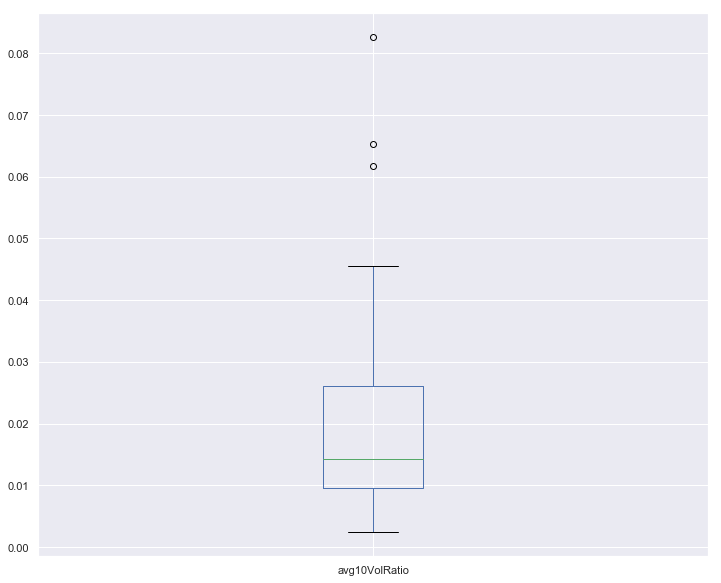

In [25]:
#Check for outliers, 10-day:
bank_stats.boxplot(column = 'avg10VolRatio')

(0, 0.11454375281302379)

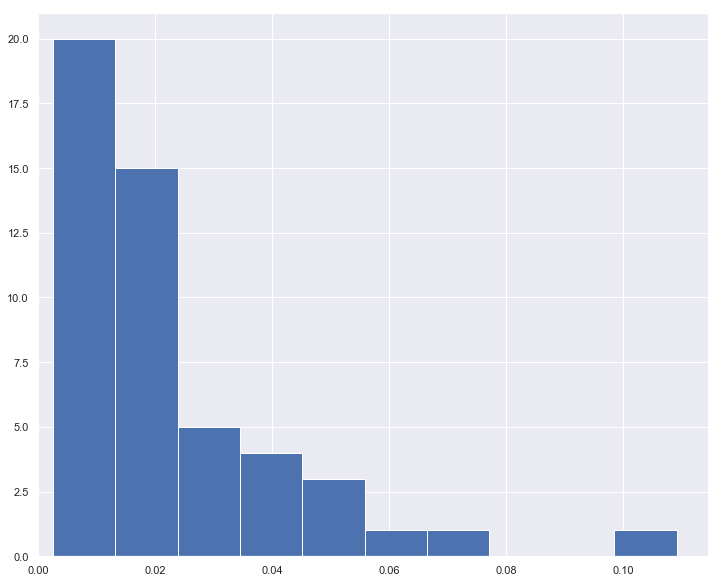

In [26]:
#Clean and inspect data visually, 30-day
sns.set(rc={'figure.figsize':(12,10)})
bank_stats.avg30VolRatio.dropna(axis=0, inplace=True)
bank_stats.avg30VolRatio.hist()
plt.xlim(0, None)

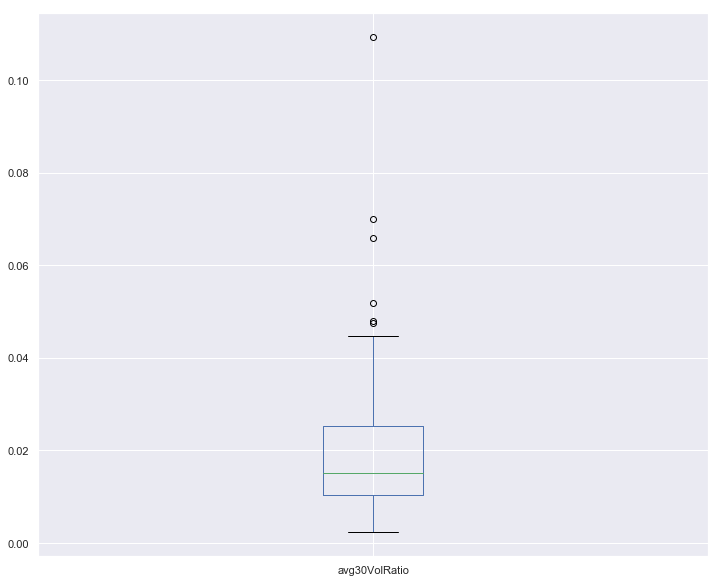

In [27]:
#Check for outliers, 30-day:
sns.set(rc={'figure.figsize':(12,10)})
bank_stats.boxplot(column = 'avg30VolRatio')

In order to compare these two groups one needs a paired t-test compares the 
means of the same group at two different times (e.g., reaction times for the same people on a task before 
or after a training period). In other words, use Welch's test for samples assessed at different times, before and after treatment. Just as student's  t-test is a useful adaptation of the normal distribution which can lead to better likelihood estimates under certain conditions, the Welch's  t-test is a further adaptation that account for additional pertubations in the underlying assumptions of the model. Specifically, the student's  t-test assumes that the samples are of equal size and equal variance. When these assumptions are not met, then Welch's  t-test provides a more accurate p-value. 

In [28]:
#Welch's Test to compare avgVol/MarcetCap at two different times, using 10-day and 30-day avergages:
import scipy.stats as stats
import numpy as np
#Step 1: compute  welch_t
avg10 = bank_stats.avg10VolRatio
avg30 = bank_stats.avg30VolRatio
num1 = avg10.mean() - avg30.mean()
denom1 = np.sqrt(avg10.var(ddof = 1)/len(avg10) + avg30.var(ddof =1)/len(avg30))
welch_t = np.abs(num1/denom1)
print("Critical t: ", welch_t)

#Step 2: compute the effective degrees of freedom for 2 samples
s1 = avg10.var(ddof=1)
s2 = avg30.var(ddof=1)
n1 = len(avg10)
n2 = len(avg30)
num2 = (s1/n1 + s2/n2)**2
denom2 = (s1/n1)**2/(n1-1)+(s2/n2)**2/(n2-1)
welch_df = num2/denom2
print("Degrees of freedom: ",welch_df)

#Step 3: compute p-value for the to samples using cdf function from scipy library
p_value = 1-stats.t.cdf(welch_t, welch_df)
print("P-value: ",p_value)


Critical t:  0.44664246343132236
Degrees of freedom:  95.06197033663354
P-value:  0.3280745401990973


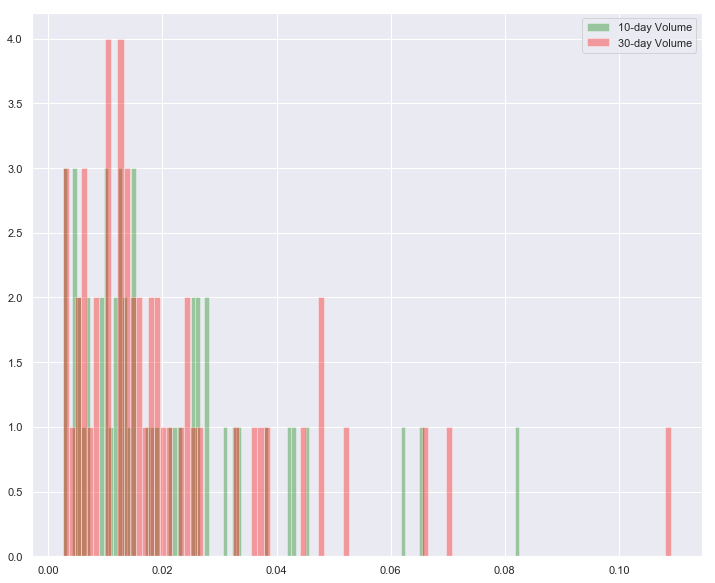

In [29]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
plt.hist(avg10, bins=100, alpha=.35, label='10-day Volume',  color='green')
plt.hist(avg30, bins=100, alpha=.35, label='30-day Volume', color='red')
plt.legend()

plt.show()

### 3. Market Cap Size & P/E Ratio

>**Question**: Is there a significant difference in P/E Ratio between banks with large and small market capitalization?

In [3]:
# drop na value for marketcap
bank_stats.dropna(subset=['marketcap'], inplace=True)
# sort value according to the market cap 
bank_stats.sort_values(by=['marketcap'], inplace=True)
# reset index
bank_stats.reset_index(inplace=True)

If you take a look at the sample of all 50 Banks, the P/E Ratio mean is around 11.6 with datapoints in both the upper and lower tails of the distribution (as seen below).

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


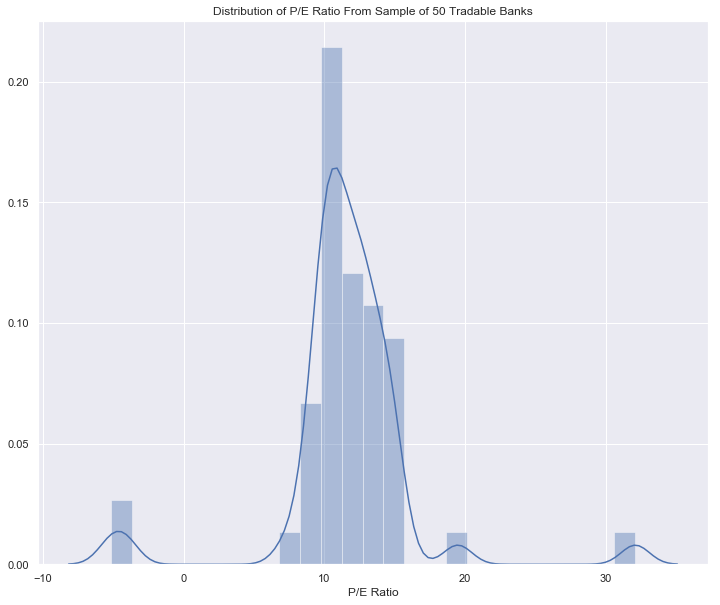

11.6158

In [4]:
# plot bank pe distribution 
sns.set_context('poster')
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(bank_stats.peRatio) # Blue distribution
plt.title('Distribution of P/E Ratio From Sample of 50 Tradable Banks')
plt.xlabel('P/E Ratio')
plt.show()
# find exact mean of p/e ratio for all 50 banks
bank_stats.peRatio.mean()

Because we are interested in seeing if there is a difference in the p/e ratio for banks with both large and small market cap, we ordered the data by market cap size and split the dataset in half. Our new datasets are small_cap (25 of the banks with lowest market cap) and big_cap (25 of the banks with the highest market cap). 

In [5]:
# split the dataset of 50 banks into large and small captilized banks
small_cap = bank_stats.iloc[0:25, :]
big_cap = bank_stats.iloc[25:, :]

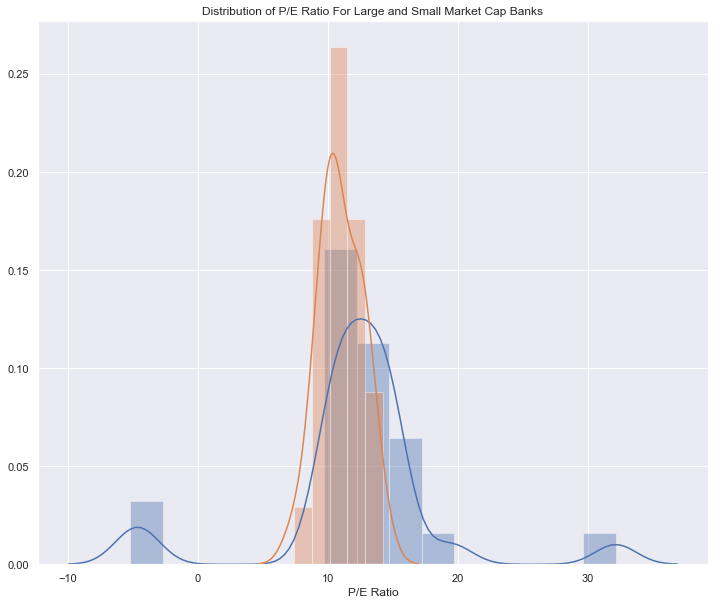

small_cap pe ratio mean: 12.243599999999999
big_cap pe ratio mean: 10.988


In [6]:
# PE distributions for small and big market cap banks
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(small_cap.peRatio) # Blue distribution
sns.distplot(big_cap.peRatio) # Orange distribution
plt.title('Distribution of P/E Ratio For Large and Small Market Cap Banks')
plt.xlabel('P/E Ratio')
plt.show()
print('small_cap pe ratio mean:', small_cap.peRatio.mean())
print('big_cap pe ratio mean:', big_cap.peRatio.mean())

From the distribution above, we see that banks with small market cap have higher p/e ratio variance. From the above plot, we also see that the p/e ratio mean of small market cap banks is slightly higher than the ratio for big market cap banks (12.24 and 10.99 respectively). This gives us cause to test if the mean p/e ratio for small market cap banks is higher than for large market cap banks. 

##### i. Null & alternative hypothesis

$H_{0}$: The mean difference between small market cap and big market cap is zero. 
> $$H_{0}: \bar{X}_{high-marketcap} = \bar{X}_{low-marketcap}$$

$H_{a}$: The mean difference for our p/e ratio for small maket cap and big market cap banks is different than zero. 
> $$H_{a}: \bar{X}_{high-marketcap} \neq \bar{X}_{low-marketcap}$$

##### ii. Choose significance Level

We are performing a 2-tailed t-test. 

>Significance level: $\alpha$ = 0.05

##### iii. Compute Welche's T

In [24]:
#Step 1: compute  welch_t
big_cap_pe = big_cap.peRatio
small_cap_pe = small_cap.peRatio
welch_t = welch_ttest(big_cap_pe, small_cap_pe)
print('Critical t-statistic', welch_t)

Critical t-statistic 0.9065294498918851


##### iv. Compute degrees of freedom

In [25]:
#Step 2: compute the effective degrees of freedom for 2 samples
dof = len(big_cap_pe) - 1
print('Degrees of Freedom:', dof)

Degrees of Freedom: 24


##### v. Compute the p-value

In [26]:
#Step 3: compute p-value for the to samples using cdf function from scipy library
pval_2sided = compute_pval_singlesided(welch_t, dof)*2
print('P-Value Two-sided:', pval_2sided)

P-Value Two-sided: 0.3736677757959339


<font color='red'>Fail to reject the null</font>

### 4. Market Cap Size & EPS


>**Question**: Is there a significant difference in EPS between banks with large and small market capitalization?

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


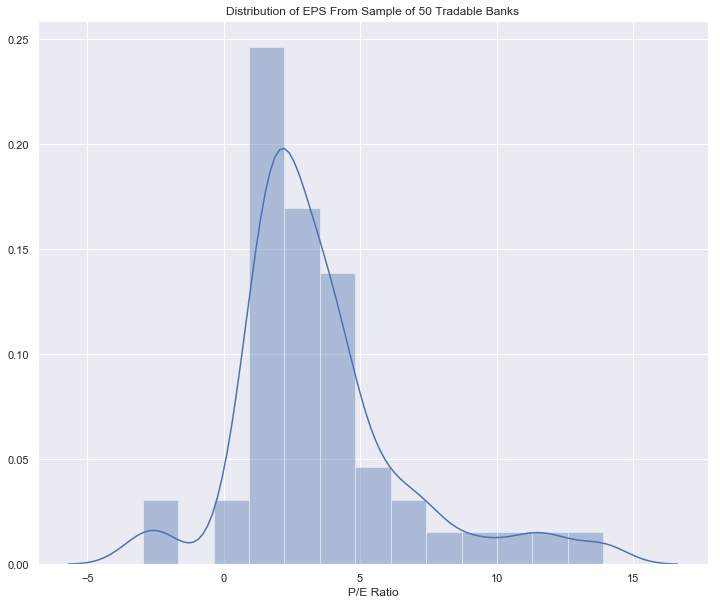

In [33]:
sns.set_context('talk')
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(bank_stats.ttmEPS) # Blue distribution
plt.title('Distribution of EPS From Sample of 50 Tradable Banks')
plt.xlabel('P/E Ratio')
plt.show()

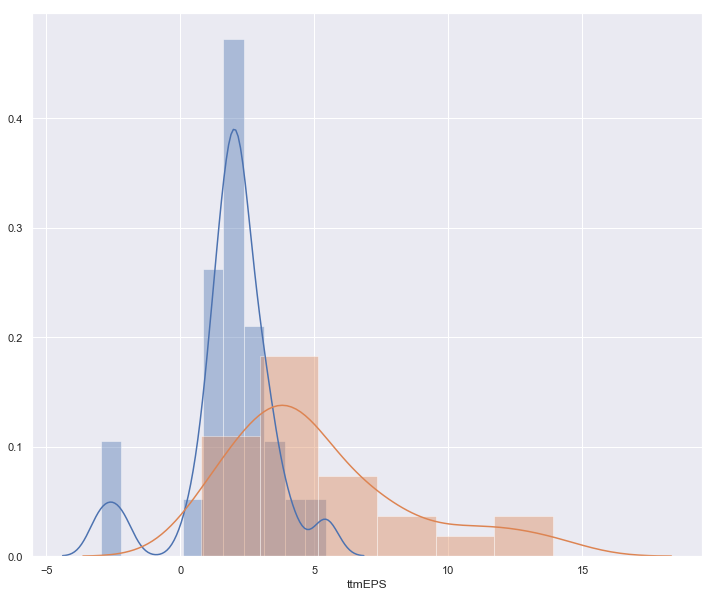

In [8]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(small_cap.ttmEPS) # Blue distribution
sns.distplot(big_cap.ttmEPS) # Orange distribution
plt.title('Distribution of EPS For Large and Small Market Cap Banks')
plt.xlabel('P/E Ratio')
plt.show()

From the distribution, we see that EPS of banks with larger market capitilization is higher than for those banks with lower market capitilization. This could be interesting to look into. 

### IV. Analysis (Hypothesis Testing) 

##### i. Null & alternative hypothesis

$H_{0}$: The mean difference for EPS between small market cap and big market cap is zero. 
> $$H_{0}: \bar{X}_{high-marketcap} = \bar{X}_{low-marketcap}$$

$H_{a}$: The mean difference for EPS for small maket cap and big market cap banks is different than zero. 
> $$H_{a}: \bar{X}_{high-marketcap} \neq \bar{X}_{low-marketcap}$$

##### ii. Choose significance Level

We are performing a 2-tailed t-test. 

>**Significance level: $\alpha$ = 0.05**

##### iii. Compute Welche's T

In [28]:
#Step 1: compute  welch_t
big_cap_eps = big_cap.ttmEPS
small_cap_eps = small_cap.ttmEPS
welch_t = welch_ttest(big_cap_eps, small_cap_eps)
print('Critical t-statistic', welch_t)

Critical t-statistic 4.379282409694951


##### iv. Compute degrees of freedom

In [30]:
#Step 2: compute the effective degrees of freedom for 2 samples
dof = len(big_cap_eps) - 1
print('Degrees of Freedom:', dof)

Degrees of Freedom: 24


##### v. Compute the p-value

In [31]:
#Step 3: compute p-value for the to samples using cdf function from scipy library
pval_2sided = compute_pval_singlesided(welch_t, dof)*2
print('P-Value Two-sided:', pval_2sided)

P-Value Two-sided: 0.00020134426405737926


<font color='red'>Reject the null hypothesis.</font>

--------------------------

### V. Recommendations/ Implementation/ Strategy 

<font color='red'>first, need to start with what your questions are. Need to fill this in with findings. One part of recommendations could be future questions to ask. The other part is, with teh questions that we did there is other analysis that could be done. Give an overview of what small cap large cap means, give an overcci

1. introduce data
1. introduce the metrics that we are using 
1. introduce questions (hypothesis)
1. introduce analysis 


(can split them up one by one. Don't have to do these here)

Presentation is at 2:30 tomorrow. Will send out randomly assigned presentation orders 15 minutes early. Then will have the science fair at 4pm afterwards. Will not be looking at notebooks until Friday. 

Readme should not contain content. Could tell you where exactly everything is. Helper functions, data, etc are here here here. It tells you what the project is and meta data about the project. </font>

<font color='red'>Make sure that the histograms that you are using. its the width of the bin not the number of bins. Got hist keywords. Need to find examples of defining bin size of the thing and set to be equal. </font>

<font color='red'>Independent t-test</font>

# QUESTIONS FOR ANDY: 

1. Should we write our own functions for the hypothesis tests? 
1. Do we need to come up with a recommendation based on a hypothesis
1. I would like to write a few classes for this project. What could that look like? 
1. I have heard you say a number of times that jupyter notebooks are not for reporting. If not in jupyter notebooks how do people usually report findings? 
1. is it reasonable to look at volume two weeks ago and a month ago (can welch test be used for)? 